In [ ]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import time
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

NUM_CLASSES = 2
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 16
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = 'small_dog_cat_dataset'

class CatDogDataset(Dataset):
    def __init__(self, file_dir, transforms= None):
        self.file_dir = file_dir
        self.transform = transforms
        self.y = np.array([])
        self.img_dataset = []
        
        for index, animal in enumerate(os.listdir(file_dir)):
            img_path = os.path.join(file_dir, animal)
            img_animal = [os.path.join(img_path, img) for img in os.listdir(img_path)]
            self.img_dataset = np.concatenate((self.img_dataset, img_animal))
            label = np.full(shape= (len(img_animal), ), fill_value= index)
            self.y = np.concatenate((self.y, label))


    def __getitem__(self, index):
        img = Image.open(self.img_dataset[index])
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label    
    def __len__(self):
        return len(self.y)

def compute_mean_and_std(path):
    resize_transform = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])
    train_dataset = CatDogDataset(file_dir= os.path.join(path,'train'), transforms= resize_transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size= len(train_dataset), shuffle=True)

    train_mean = []
    train_std = []

    for i, image in enumerate(train_loader, 0):
        numpy_image = image[0].numpy()
        
        batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
        batch_std = np.std(numpy_image, axis=(0, 2, 3))
        
        train_mean.append(batch_mean)
        train_std.append(batch_std)

    train_mean = torch.tensor(np.mean(train_mean, axis=0))
    train_std = torch.tensor(np.mean(train_std, axis=0))

    return train_mean, train_std

def augment_data(path, img_shape, train_mean, train_std):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(img_shape, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(train_mean, train_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize([img_shape, img_shape]),
            transforms.ToTensor(),
            transforms.Normalize(train_mean, train_std)
        ]),
    }

    train_dataset = CatDogDataset(file_dir= os.path.join(path,'train'), transforms= data_transforms['train'])
    train_loader = DataLoader(dataset=train_dataset, batch_size= 16, shuffle= True)

    test_dataset = CatDogDataset(file_dir= os.path.join(path, 'test'), transforms= data_transforms['test'])
    test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle= True)

    return train_dataset, train_loader, test_dataset, test_loader

class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()

        self.num_classes = num_classes
        self.num_of_blocks = 5
        self.filters = [64, 128, 256, 512, 512]
        self.flatten = nn.Flatten()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels= 3,
                      out_channels= self.filters[0],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= self.filters[0],
                      out_channels= self.filters[0],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (2, 2),
                         stride= (2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels= self.filters[0],
                      out_channels= self.filters[1],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= self.filters[1],
                      out_channels= self.filters[1],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (2, 2),
                         stride= (2, 2))
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels= self.filters[1],
                      out_channels= self.filters[2],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[2],
                      out_channels= self.filters[2],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[2],
                      out_channels= self.filters[2],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[2],
                      out_channels= self.filters[2],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),            

            nn.MaxPool2d(kernel_size= (2, 2),
                         stride= (2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels= self.filters[2],
                      out_channels= self.filters[3],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[3],
                      out_channels= self.filters[3],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[3],
                      out_channels= self.filters[3],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels= self.filters[3],
                      out_channels= self.filters[3],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),            

            nn.MaxPool2d(kernel_size= (2, 2),
                         stride= (2, 2))
        )
        
        self.block_5 = nn.Sequential(
            nn.Conv2d(in_channels= self.filters[3],
                      out_channels= self.filters[4],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[4],
                      out_channels= self.filters[4],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),

            nn.Conv2d(in_channels= self.filters[4],
                      out_channels= self.filters[4],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels= self.filters[4],
                      out_channels= self.filters[4],
                      kernel_size= (3, 3),
                      stride= (1, 1),
                      padding= 1),
            nn.ReLU(),            

            nn.MaxPool2d(kernel_size= (2, 2),
                         stride= (2, 2))
        )

        self.dense = nn.Sequential(
            nn.Linear(in_features= 2*2*512, out_features= 512),
            nn.ReLU(),
            nn.Linear(in_features= 512, out_features= 512),
            nn.ReLU(),
            nn.Linear(in_features= 512, out_features= self.num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        x = self.flatten(x)
        logits = self.dense(x)
        propability = F.softmax(logits, dim= 1)
        return logits, propability
        # return logits

def training(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    correct = 0
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(DEVICE)
        y = y.type(torch.LongTensor)
        y = y.to(DEVICE)
        y_hat, probability = model(X)
        loss = criterion(y_hat, y)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_batch = (y_hat.argmax(1) == y).type(torch.float).sum().item()
        correct += correct_batch

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset)}]")

    batch_accuracy = correct / size
    batch_loss = train_loss / len(dataloader)
    return batch_loss, batch_accuracy

def testing(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for (X, y) in dataloader:
            X = X.to(DEVICE)
            y = y.type(torch.LongTensor)
            y = y.to(DEVICE)

            y_hat, probability = model(X)
            loss = criterion(y_hat, y)
            test_loss += loss.item()
            correct_batch = (y_hat.argmax(1) == y).type(torch.float).sum().item()
            correct += correct_batch
            
    batch_accuracy = correct / size
    batch_loss = test_loss / len(dataloader)
    return batch_loss, batch_accuracy

def visualization(train_loss, test_loss, train_accuracy, test_accuracy):
    plt.figure(figsize= (8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='loss')
    plt.plot(test_loss, label='test_loss')
    plt.ylim([0, 3])

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='accuracy')
    plt.plot(test_accuracy, label='val_accuracy')
    plt.ylim([0.2, 1])

    plt.show()

def train_model(model, train_loader, test_loader, n_epochs, criterion, optimizer, ):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()
        print(f"Epoch {epoch+1}/{n_epochs}")
        train_epoch_loss, train_epoch_accuracy = training(dataloader= train_loader, model= model, criterion= criterion, optimizer= optimizer)
        test_epoch_loss, test_epoch_accuracy = testing(dataloader= test_loader, model= model, criterion= criterion, optimizer= optimizer)
        elapsed_time = time.time() - start_time
        
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        test_loss.append(test_epoch_loss)
        test_accuracy.append(test_epoch_accuracy)

        print("----------------------------------------")
        print(f"{len(train_loader)}/{len(train_loader)} - {int(elapsed_time)}s - loss: {train_epoch_loss} - accuracy: {train_epoch_accuracy} - val_loss: {test_epoch_loss} - val_accuracy: {test_epoch_accuracy}")
        print("==========================================================================================")
    return train_loss, test_loss, train_accuracy, test_accuracy


In [ ]:
train_mean, train_std = compute_mean_and_std(path= PATH)
train_dataset, train_loader, test_dataset, test_loader = augment_data(path= PATH, img_shape= 64, train_mean= train_mean, train_std= train_std)

model = VGG19(NUM_CLASSES).to(DEVICE)
print(model)

VGG19(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 256, kerne

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr= LEARNING_RATE)

In [ ]:
train_loss, test_loss, train_accuracy, test_accuracy = train_model(train_loader= train_loader, 
                                                                   test_loader= test_loader, 
                                                                   model= model, 
                                                                   criterion= criterion, 
                                                                   optimizer= optimizer, 
                                                                   n_epochs= NUM_EPOCHS)

Epoch 1/100
loss: 730.413574  [    0/2000]
loss: 10.100811  [  160/2000]
loss: 2.632952  [  320/2000]
loss: 0.678148  [  480/2000]
loss: 0.698843  [  640/2000]
loss: 0.667299  [  800/2000]
loss: 0.714776  [  960/2000]
loss: 0.857500  [ 1120/2000]
loss: 0.705620  [ 1280/2000]
loss: 0.707940  [ 1440/2000]
loss: 0.704821  [ 1600/2000]
loss: 0.716804  [ 1760/2000]
loss: 0.687848  [ 1920/2000]
----------------------------------------
125/125 - 23s - loss: 487.3695394091606 - accuracy: 0.5125 - val_loss: 0.6829926450001566 - val_accuracy: 0.575
Epoch 2/100
loss: 0.661556  [    0/2000]
loss: 0.674422  [  160/2000]
loss: 0.697562  [  320/2000]
loss: 0.850185  [  480/2000]
loss: 0.688569  [  640/2000]
loss: 0.720119  [  800/2000]
loss: 0.731347  [  960/2000]
loss: 0.665782  [ 1120/2000]
loss: 0.714847  [ 1280/2000]
loss: 0.651385  [ 1440/2000]
loss: 0.659688  [ 1600/2000]
loss: 0.655746  [ 1760/2000]
loss: 0.666431  [ 1920/2000]
----------------------------------------
125/125 - 16s - loss: 0.6

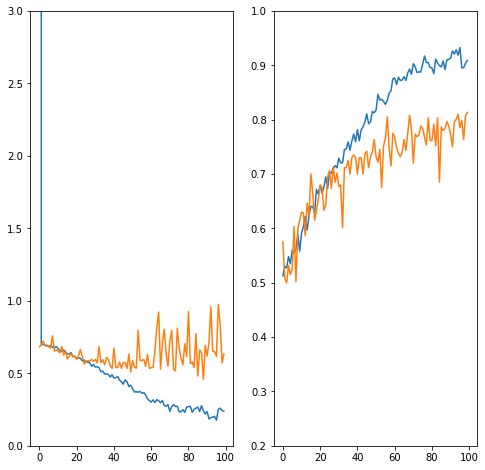

In [ ]:
visualization(train_loss, test_loss, train_accuracy, test_accuracy)

In [ ]:
def visualization(train_loss, test_loss, train_accuracy, test_accuracy):
    plt.figure(figsize= (8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='loss')
    plt.plot(test_loss, label='test_loss')
    plt.ylim([0, 1.2])

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='accuracy')
    plt.plot(test_accuracy, label='val_accuracy')
    plt.ylim([0.45, 1])

    plt.show()

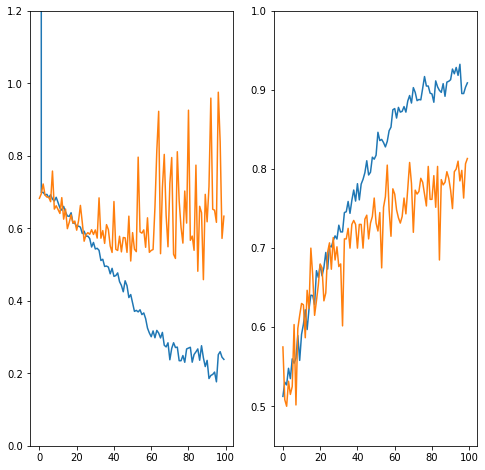

In [ ]:
visualization(train_loss, test_loss, train_accuracy, test_accuracy)

# **Transfer learning with VGG19**

In [ ]:
model_tf = models.vgg19(pretrained= True)
print(model_tf)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
last_layer = nn.Linear(4096, 2)
model_tf.classifier[6] = last_layer
print(model_tf)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model_tf = model_tf.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_tf.parameters(), lr= LEARNING_RATE)

In [ ]:
def training_tf(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    correct = 0
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(DEVICE)
        y = y.type(torch.LongTensor)
        y = y.to(DEVICE)
        y_hat = model(X)
        loss = criterion(y_hat, y)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_batch = (y_hat.argmax(1) == y).type(torch.float).sum().item()
        correct += correct_batch

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset)}]")

    batch_accuracy = correct / size
    batch_loss = train_loss / len(dataloader)
    return batch_loss, batch_accuracy

def testing_tf(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for (X, y) in dataloader:
            X = X.to(DEVICE)
            y = y.type(torch.LongTensor)
            y = y.to(DEVICE)

            y_hat = model(X)
            loss = criterion(y_hat, y)
            test_loss += loss.item()
            correct_batch = (y_hat.argmax(1) == y).type(torch.float).sum().item()
            correct += correct_batch
            
    batch_accuracy = correct / size
    batch_loss = test_loss / len(dataloader)
    return batch_loss, batch_accuracy

def train_model(model, train_loader, test_loader, n_epochs, criterion, optimizer, ):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()
        print(f"Epoch {epoch+1}/{n_epochs}")
        train_epoch_loss, train_epoch_accuracy = training_tf(dataloader= train_loader, model= model, criterion= criterion, optimizer= optimizer)
        test_epoch_loss, test_epoch_accuracy = testing_tf(dataloader= test_loader, model= model, criterion= criterion, optimizer= optimizer)
        elapsed_time = time.time() - start_time
        
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        test_loss.append(test_epoch_loss)
        test_accuracy.append(test_epoch_accuracy)

        print("----------------------------------------")
        print(f"{len(train_loader)}/{len(train_loader)} - {int(elapsed_time)}s - loss: {train_epoch_loss} - accuracy: {train_epoch_accuracy} - val_loss: {test_epoch_loss} - val_accuracy: {test_epoch_accuracy}")
        print("==========================================================================================")
    return train_loss, test_loss, train_accuracy, test_accuracy

In [ ]:
train_loss, test_loss, train_accuracy, test_accuracy = train_model(train_loader= train_loader, 
                                                                   test_loader= test_loader, 
                                                                   model= model_tf, 
                                                                   criterion= criterion, 
                                                                   optimizer= optimizer, 
                                                                   n_epochs= NUM_EPOCHS)

loss: 0.698614  [  640/2000]
loss: 0.681623  [  800/2000]
loss: 0.695628  [  960/2000]
loss: 0.689356  [ 1120/2000]
loss: 0.680004  [ 1280/2000]
loss: 0.693047  [ 1440/2000]
loss: 0.696161  [ 1600/2000]
loss: 0.688780  [ 1760/2000]
loss: 0.697632  [ 1920/2000]
----------------------------------------
125/125 - 29s - loss: 0.695841513633728 - accuracy: 0.482 - val_loss: 0.6979446818954066 - val_accuracy: 0.5
Epoch 29/100
loss: 0.713765  [    0/2000]
loss: 0.686887  [  160/2000]
loss: 0.704363  [  320/2000]
loss: 0.690122  [  480/2000]
loss: 0.692728  [  640/2000]
loss: 0.692129  [  800/2000]
loss: 0.676619  [  960/2000]
loss: 0.698103  [ 1120/2000]
loss: 0.702812  [ 1280/2000]
loss: 0.680015  [ 1440/2000]
loss: 0.695714  [ 1600/2000]
loss: 0.657425  [ 1760/2000]
loss: 0.645472  [ 1920/2000]
----------------------------------------
125/125 - 29s - loss: 0.69494411277771 - accuracy: 0.5095 - val_loss: 0.6979450457974484 - val_accuracy: 0.5
Epoch 30/100
loss: 0.700708  [    0/2000]
loss: 0

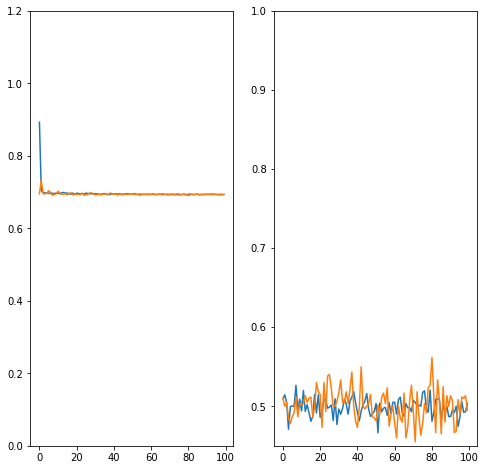

In [ ]:
visualization(train_loss, test_loss, train_accuracy, test_accuracy)